## First try in class
Give it a name
 - notebook instance type: ml.m4.xlarge
 - platform identifier type: notebook-al2-v1
 - lifecycle config: ml-pipeline

In [ ]:
# !pip install xlrd
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sagemaker.image_uris import retrieve
import sagemaker
import requests
import zipfile
import numpy as np
import boto3
import io
import os

In [ ]:
# Specify the GitHub URL of the ZIP file
github_url = 'https://github.com/mjochen/CloudAI/raw/master/Exercises/files/food-twentieth-century-crop-statistics-1900-2017-xlsx.zip'

# Step 1: Download the ZIP file from GitHub
response = requests.get(github_url)

# ... (previous code)

if response.status_code == 200:
    # Step 2: Read the ZIP file content into a BytesIO object
    zip_data = io.BytesIO(response.content)

    # Step 3: Extract the Excel file from the ZIP
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        # Assuming there's only one file in the ZIP, you can extract it
        file_list = zip_ref.namelist()
        if len(file_list) > 0:
            with zip_ref.open(file_list[0]) as extracted_file:
                # List all sheet names in the Excel file
                sheet_names = pd.ExcelFile(extracted_file).sheet_names
                # Check if 'CropStats' is in the list of sheet names
                if 'CropStats' in sheet_names:
                    df = pd.read_excel(extracted_file, sheet_name='CropStats', engine='openpyxl', usecols=lambda name: name != 'Unnamed: 0')
                    # Now, you can work with the DataFrame 'df' as usual
                else:
                    print("The 'CropStats' sheet does not exist in the Excel file.")
        else:
            print("The ZIP file is empty.")
else:
    print("Failed to retrieve the ZIP file from GitHub.")

df.head()

In [ ]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
df.shape
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df, 
                                            test_size=0.2, 
                                            random_state=42)
#                                             stratify=df_wine['quality'])
test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=42)
#                                   stratify=test_and_validate['quality'])
print(train.shape)
print(test.shape)
print(validate.shape)

In [ ]:
bucket='c93435a2086654l4910637t1w0854223549-sandboxbucket-jtqmwpnickrd'
prefix='CropDataModelHannah'
train_file='wine_train.csv'
test_file='wine_test.csv'
validate_file='wine_validate.csv'
whole_file='wine.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [ ]:
from sagemaker.image_uris import retrieve
import sagemaker
role=sagemaker.get_execution_role()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

In [ ]:
hyperparams={
    "num_round":"20",
    "num_class":"7",
    "objective":"multi:softmax"}

In [ ]:
xgb_model=sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [ ]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [ ]:
xgb_model.fit(inputs=data_channels, logs=False)

In [ ]:
s=sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:merror', 
                                                         'validation:merror']
                                        )

s_df=s.dataframe()
s_df = s_df.iloc[:,1:3]
s_df

## Second try at home
Give it a name
 - notebook instance type: ml.m4.xlarge
 - platform identifier type: notebook-al2-v1
 - lifecycle config: ml-pipeline

I used an s3 bucket where my excel file with the dataset was stored. I needed to install some extentions before I got my dataset. Then I imported the dataset from my bucket inside my Jupyter and read my file. I also removed the first column of my dataset because this was unnecessary.

In [ ]:
!pip install openpyxl
!pip install awswrangler
import openpyxl
import awswrangler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# s3_path = "s3://<your-bucket-name>/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx"
s3_path = "s3://c93435a2086654l4910637t1w0854223549-sandboxbucket-1plhvhnq75z2w/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx"
df = awswrangler.s3.read_excel(s3_path, sheet_name="CropStats", usecols=lambda name: name != 'Unnamed: 0')
print(df.head())

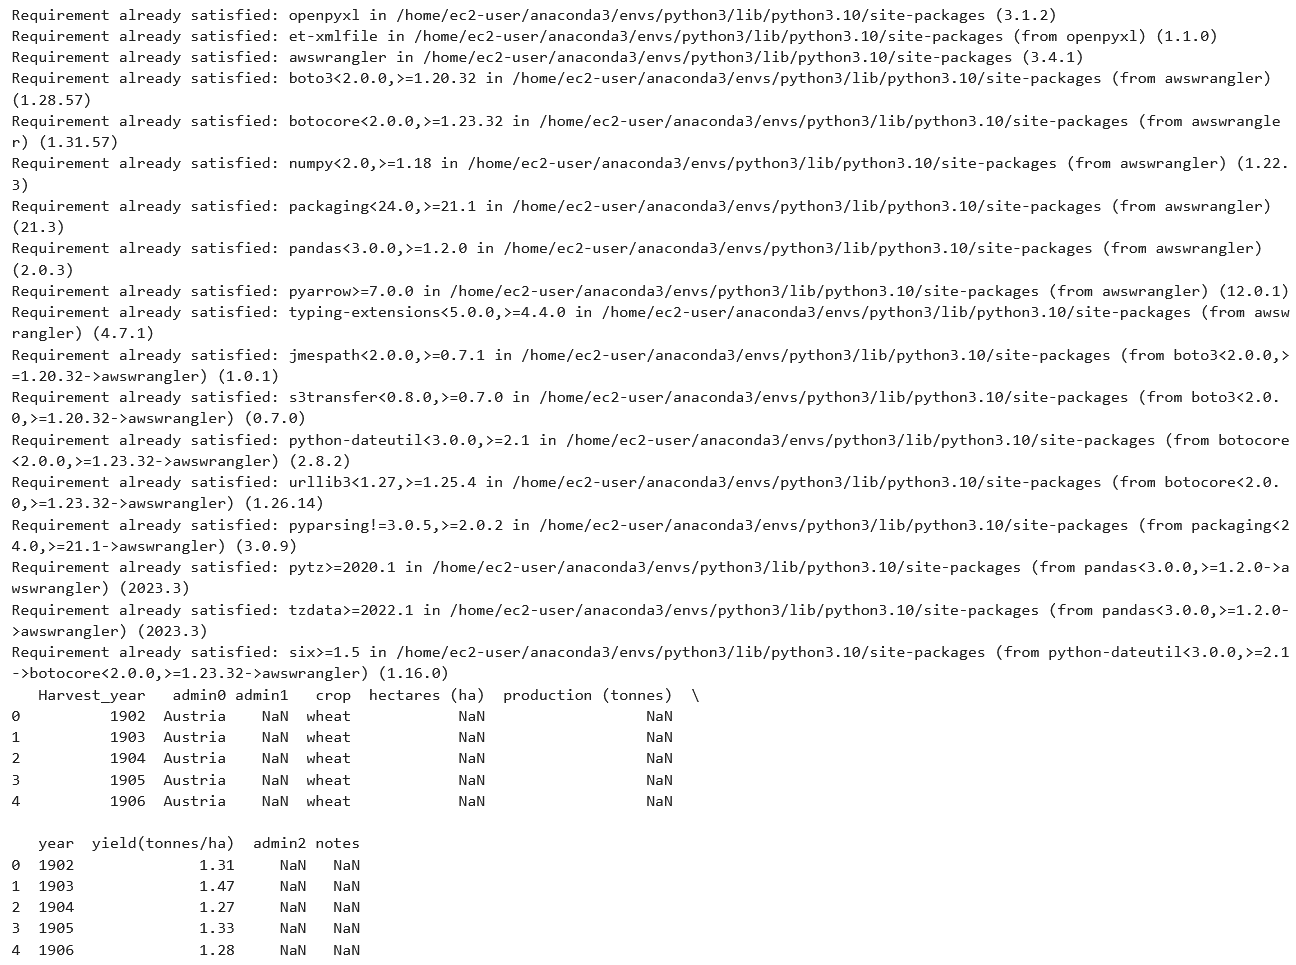

Clean the data like the EDA clean dataset.

In [ ]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])
print(df.head())

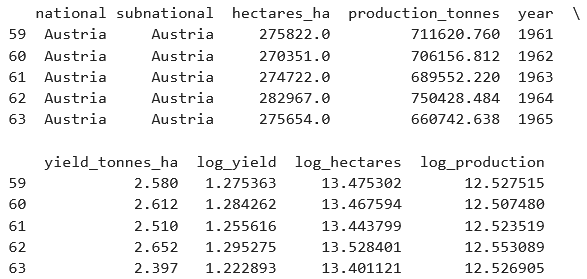

Split the dataset into 3 different set: train, test and validate data.

In [ ]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df, 
                                            test_size=0.2, 
                                            random_state=42)
#                                             stratify=df_wine['quality'])
test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=42)
#                                   stratify=test_and_validate['quality'])
print(train.shape)
print(test.shape)
print(validate.shape)

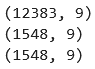

We upload these dataset to the bucket were our original dataset is found. These files can be found under the name CropDataModelHannah.

In [ ]:
# bucket='c93435a2086654l4910637t1w0854223549-sandboxbucket-jtqmwpnickrd'
bucket='c93435a2086654l4910637t1w0854223549-sandboxbucket-1plhvhnq75z2w'
prefix='CropDataModelHannah'
train_file='crop_train.csv'
test_file='crop_test.csv'
validate_file='crop_validate.csv'
whole_file='crop.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

-- no output --

We create the model LinearRegression.

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
lr = LinearRegression()

# Fit the model to the training data
lr.fit(train[['hectares_ha', 'production_tonnes']], train['yield_tonnes_ha'])

# Make predictions on the test data
test_predictions = lr.predict(test[['hectares_ha', 'production_tonnes']])

# Calculate the mean squared error (MSE) on the test data
mse = np.mean((test_predictions - test['yield_tonnes_ha'])**2)

# Print the MSE
print('MSE:', mse)

We save the model to s3.

In [ ]:
import pickle
# Save the trained model to S3
with open('model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Upload the trained model to S3
s3.upload_file('model.pkl', bucket, os.path.join(prefix, 'model', 'model.pkl'))

We make a Residual Analysis and see that the model is not optimised to make predictions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot
plt.scatter(test_predictions, test_predictions - test['yield_tonnes_ha'])

# Add a title and axis labels
plt.title('Residual Analysis')
plt.xlabel('Predicted Yield (tonnes/ha)')
plt.ylabel('Residual (tonnes/ha)')

# Show the plot
plt.show()

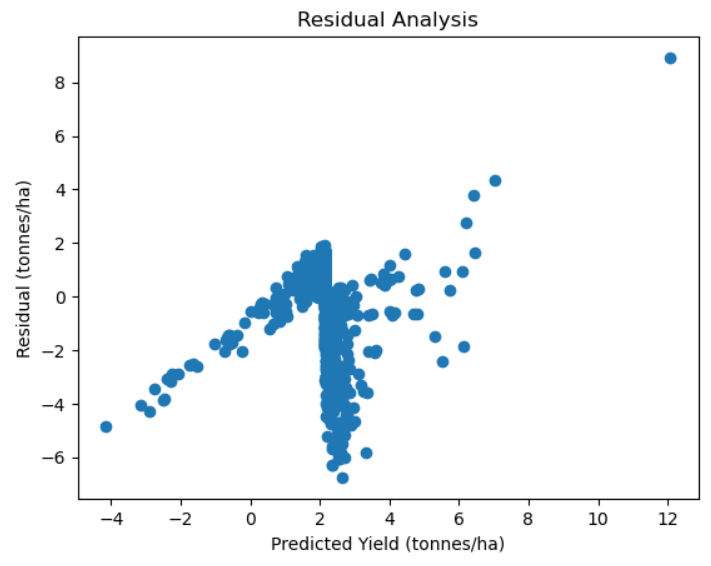